In [19]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import h5py
from plot3D import *

In [20]:
def array_to_color(array, cmap="Oranges"):
    s_m = plt.cm.ScalarMappable(cmap=cmap)
    return s_m.to_rgba(array)[:,:-1]


def rgb_data_transform(data):
    data_t = []
    for i in range(data.shape[0]):
        data_t.append(array_to_color(data[i]).reshape(16, 16, 16, 3))
    return np.asarray(data_t, dtype=np.float32)

In [77]:
with h5py.File("./train_point_clouds.h5", "r") as hf:    
    a = hf["0"]
    b = a['img'][:]
    s = a['points'][:]

Text(0.5, 1.0, 'The figure 5 in 2d')

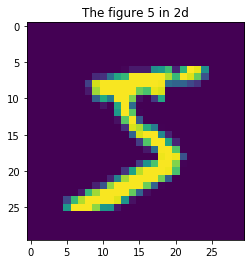

In [94]:
plt.imshow(b)
plt.title('The figure 5 in 2d')

Text(0.5, 0.92, 'The figure 5 in 3d Cloud point')

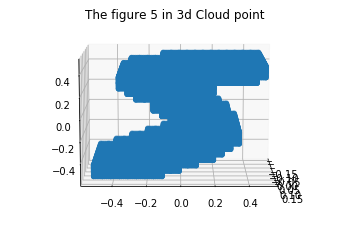

In [93]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(s[:,0], s[:,1], zs=s[:,2])
ax.view_init(10, 0)
plt.title('The figure 5 in 3d Cloud point')


In [83]:
s[:,0]

array([0.15, 0.15, 0.15, ..., 0.15, 0.15, 0.15])

In [21]:
with h5py.File("./full_dataset_vectors.h5", "r") as hf:    

    # Split the data into training/test features/targets
    X_train = hf["X_train"][:]
    targets_train = hf["y_train"][:]
    X_test = hf["X_test"][:] 
    targets_test = hf["y_test"][:]

    # Determine sample shape
    sample_shape = (16, 16, 16, 3)

    # Reshape data into 3D format
    X_train = rgb_data_transform(X_train)
    X_test = rgb_data_transform(X_test)

    # Convert target vectors to categorical targets
    targets_train = to_categorical(targets_train).astype(np.integer)
    targets_test = to_categorical(targets_test).astype(np.integer)

In [25]:
X_train.shape

(10000, 16, 16, 16, 3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 14, 14, 14, 32)    2624      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 7, 7, 7, 32)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 7, 32)       128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 7, 32)       0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 5, 5, 5, 64)       55360     
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 2, 2, 2, 64)       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 2, 2, 2, 64)       256       
__________

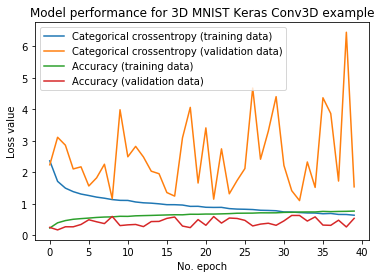

In [11]:
# Create the model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()
# Fit data to model
history = model.fit(X_train, targets_train,
            batch_size=128,
            epochs=40,
            verbose=1,
            validation_split=0.3)

# Generate generalization metrics
score = model.evaluate(X_test, targets_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# Plot history: Categorical crossentropy & Accuracy
plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
plt.plot(history.history['acc'], label='Accuracy (training data)')
plt.plot(history.history['val_acc'], label='Accuracy (validation data)')
plt.title('Model performance for 3D MNIST Keras Conv3D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()